# Introduction

This notebook contains the attempt to include additional features into the time series model developed before. The approach did not prove successfull and will not be pursued any further. Explanation and comments will therefore only be very minimalistic. Feel free to go through the code, but the results will not be relevant for further steps in this project.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, RobustScaler
%matplotlib inline

In [2]:
# load generation data
data = pd.read_csv('./processed_data/20150101-20170830-gen_per_prod_type.csv', parse_dates=True, index_col=0)

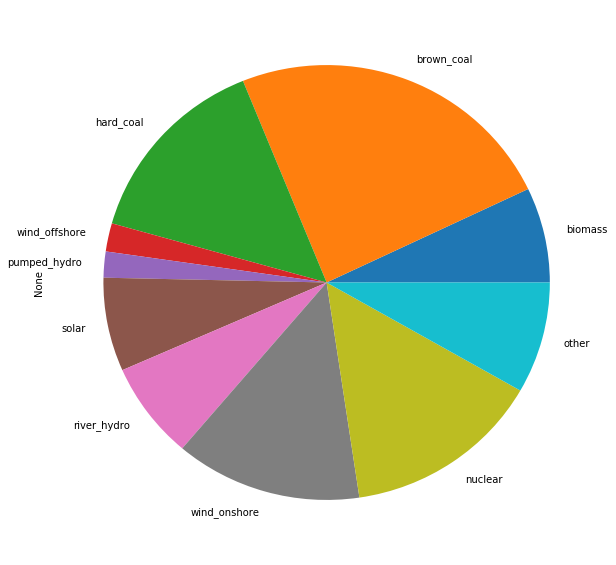

In [3]:
data.sum().plot.pie(figsize=(10, 10));

>**Note:** The scatter matrix below will require substantial computational resources. Only execute if you have enough memory available. 

In [4]:
# pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (20,20), diagonal = 'kde');

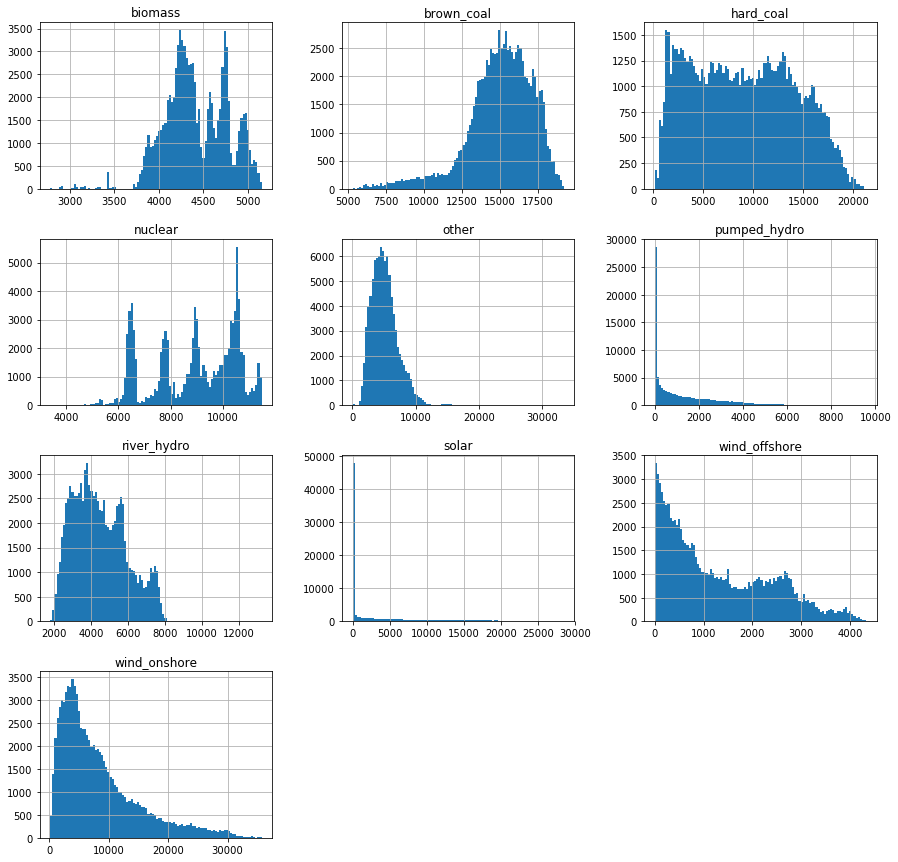

In [5]:
data.hist(figsize=(15,15), bins=100);

In [6]:
# load price data
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)

In [7]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']

In [8]:
da_prep = pd.DataFrame(index=da_raw.index)

# calculate quantiles and inter-quantile range of the data
q75 = da_raw['DA_price'].quantile(.75)
q25 = da_raw['DA_price'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaces by that value
tol = 3
da_prep['DA_price'] = da_raw['DA_price'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
da_prep['DA_price'] = da_prep['DA_price'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)

In [9]:
# pick data columns
chosen_data = data[['biomass', 'brown_coal', 'hard_coal', 'nuclear', 'other']].join(da_prep).resample('1H').mean()

In [10]:
# fill gaps in data with forward fill
chosen_data = chosen_data.fillna(method='ffill', axis=0)

In [11]:
# scale features to 0-1 range
columns = ['biomass', 'brown_coal', 'hard_coal', 'nuclear', 'other']
feature_scaler = MinMaxScaler()
chosen_data[columns] = feature_scaler.fit_transform(chosen_data[columns])

In [12]:
# scale price data to 0-1 range
label_scaler = MinMaxScaler()
chosen_data['DA_price'] = label_scaler.fit_transform(chosen_data['DA_price'].values.reshape(-1, 1))

In [ ]:
chosen_data.hist(figsize=(15,15), bins=100);

In [14]:
# apply timeseries lags to data
lags = 168
cols = chosen_data.columns
for l in range(1, lags+1):
    for col in cols:
        chosen_data['{}_l_{}'.format(col, l)] = chosen_data[col].shift(l)

In [15]:
# drop missing data inferred by lagging
chosen_data.dropna(inplace=True)

In [16]:
chosen_data.head()

,biomass,brown_coal,hard_coal,nuclear,other,DA_price,biomass_l_1,brown_coal_l_1,hard_coal_l_1,nuclear_l_1,...,hard_coal_l_167,nuclear_l_167,other_l_167,DA_price_l_167,biomass_l_168,brown_coal_l_168,hard_coal_l_168,nuclear_l_168,other_l_168,DA_price_l_168
2015-01-08 00:00:00,0.592792,0.806763,0.280736,0.982205,0.180283,0.382535,0.595426,0.795311,0.328710,0.995970,...,0.082878,0.952195,0.143024,0.358931,0.642428,0.749468,0.123748,0.905599,0.146356,0.402692
2015-01-08 01:00:00,0.593951,0.780451,0.245328,0.980500,0.174389,0.365824,0.592792,0.806763,0.280736,0.982205,...,0.077811,0.944754,0.145854,0.344301,0.625145,0.722687,0.082878,0.952195,0.143024,0.358931
2015-01-08 02:00:00,0.593740,0.777836,0.218581,0.981244,0.166046,0.344756,0.593951,0.780451,0.245328,0.980500,...,0.084280,0.944940,0.145968,0.334937,0.639688,0.685753,0.077811,0.944754,0.145854,0.344301
2015-01-08 03:00:00,0.593002,0.757457,0.216209,0.980252,0.163939,0.337083,0.593740,0.777836,0.218581,0.981244,...,0.086831,0.936818,0.145374,0.337213,0.647381,0.632245,0.084280,0.944940,0.145968,0.334937
2015-01-08 04:00:00,0.592475,0.764292,0.238477,0.981771,0.167346,0.337538,0.593002,0.757457,0.216209,0.980252,...,0.074433,0.903801,0.149550,0.334287,0.645168,0.634986,0.086831,0.936818,0.145374,0.337213


In [17]:
# create feature and label dataframes
prelim_features = chosen_data
prelim_labels = pd.DataFrame(chosen_data['DA_price'])

# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['DA_price'].shift(-i)
prelim_labels.drop('DA_price', axis=1, inplace=True)

In [18]:
# format labels as vectors with 24 entries
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features[:'2016']
features_test = features['2017':]
labels_train = labels[:'2016']

In [19]:
# get data dimensions for LSTM network 
samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

In [20]:
tensors_train = []
tensors_test = []

# pick columns (features) that should be included in the model

# cols = ['brown_coal', 'DA_price']
# cols = ['hard_coal', 'DA_price']
cols = ['nuclear', 'DA_price']
for feature in cols:
    picker = [colname for colname in features.columns if colname.startswith(feature)]
    f_train = features_train[picker].drop(feature, axis=1).as_matrix().reshape(samples_train, timesteps, 1)
    print(f_train.shape)
    tensors_train.append(f_train)
    f_test = features_test[picker].drop(feature, axis=1).as_matrix().reshape(samples_test, timesteps, 1)
    tensors_test.append(f_test)
    print(f_test.shape)

(724, 168, 1)
(242, 168, 1)
(724, 168, 1)
(242, 168, 1)


In [21]:
# stack feature tensors to one big tensor
input_train = np.stack(tensors_train, axis = -1).reshape(samples_train, timesteps, len(cols))
input_test = np.stack(tensors_test, axis = -1).reshape(samples_test, timesteps, len(cols))

In [22]:
# convert label dataframe to matrix
output_train = labels_train.as_matrix()

In [23]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

Using TensorFlow backend.


In [24]:
# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(input_train, output_train, test_size=0.2, random_state=7)

In [25]:
# double check correct data format
print(X_train.shape)
X_train

(579, 168, 2)


array([[[ 0.8484933 ,  0.32440341],
        [ 0.84973338,  0.34592626],
        [ 0.83984375,  0.31458482],
        ..., 
        [ 0.86027406,  0.37037519],
        [ 0.86055308,  0.37057026],
        [ 0.8578869 ,  0.37187073]],

       [[ 0.61604043,  0.45828727],
        [ 0.62217882,  0.4827362 ],
        [ 0.62382192,  0.48013525],
        ..., 
        [ 0.76795015,  0.36666883],
        [ 0.77061632,  0.37570713],
        [ 0.76760913,  0.38559074]],

       [[ 0.88709077,  0.42467   ],
        [ 0.88498264,  0.43845504],
        [ 0.88423859,  0.48663762],
        ..., 
        [ 0.71884301,  0.3928734 ],
        [ 0.71341766,  0.40145653],
        [ 0.72557044,  0.40119644]],

       ..., 
       [[ 0.66192336,  0.44606281],
        [ 0.6672557 ,  0.47668899],
        [ 0.65919519,  0.47746928],
        ..., 
        [ 0.67221602,  0.38526562],
        [ 0.67153398,  0.39196307],
        [ 0.6703559 ,  0.39755511]],

       [[ 0.30168031,  0.51238702],
        [ 0.30282738,  

In [26]:
# create model

conv_input_layer = Input(batch_shape=(None, X_train.shape[1], X_train.shape[2]))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = Dropout(0.1)(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(24)(x)

model = Model(inputs=[conv_input_layer], outputs=[x])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168, 2)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 16,344
Trainable params: 16,344
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='mae', optimizer='adam')
checkpoint = ModelCheckpoint('./models/multidim_timeseries_testing.hdf5', save_best_only=True)

hist = model.fit(X_train, y_train,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=50, epochs=160)

Train on 579 samples, validate on 145 samples
Epoch 1/160
579/579 [==============================] - 1s - loss: 0.4107 - val_loss: 0.3522
Epoch 2/160
579/579 [==============================] - 0s - loss: 0.2896 - val_loss: 0.2214
Epoch 3/160
579/579 [==============================] - 0s - loss: 0.2177 - val_loss: 0.1598
Epoch 4/160
579/579 [==============================] - 0s - loss: 0.1751 - val_loss: 0.1273
Epoch 5/160
579/579 [==============================] - 0s - loss: 0.1443 - val_loss: 0.1027
Epoch 6/160
579/579 [==============================] - 0s - loss: 0.1246 - val_loss: 0.0807
Epoch 7/160
579/579 [==============================] - 0s - loss: 0.1117 - val_loss: 0.0738
Epoch 8/160
579/579 [==============================] - 0s - loss: 0.1000 - val_loss: 0.0630
Epoch 9/160
579/579 [==============================] - 0s - loss: 0.0950 - val_loss: 0.0566
Epoch 10/160
579/579 [==============================] - 0s - loss: 0.0886 - val_loss: 0.0485
Epoch 11/160
579/579 [===========

In [29]:
best = load_model('./models/multidim_timeseries_testing.hdf5')
# pred = best.predict([input_test, input_test[:, :, 3]])
pred = best.predict(input_test)
pred = label_scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [30]:
print(mean_absolute_error(y_pred=pred, y_true=test_raw[:5808].DA_price.as_matrix()[:]))

6.67380970188


**Analysis** 

The multivariate timeseries model yields significantly worse results than the pure time series model. We will therefore not pursue this approach any further.